In [449]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

In [450]:
import pandas as pd

df_2017 = pd.read_excel('/content/native_Load_2017.xlsx')
df_2018 = pd.read_excel('/content/Native_Load_2018.xlsx')
df_2019 = pd.read_excel('/content/Native_Load_2019.xlsx')

df_2017 = df_2017.rename(columns={'Hour Ending':'HourEnding'})

df = pd.concat([df_2017,df_2018,df_2019])
df['HourEnding'] =df['HourEnding'].str.strip()
df[['date','time','n_c']] = df['HourEnding'].str.split(expand=True)
df['datetime'] = (pd.to_datetime(df.pop('date'), format='%m/%d/%Y') + 
                  pd.to_timedelta(df.pop('time') + ':00'))

df = df[['datetime','ERCOT']]
df.set_index('datetime', inplace = True)

df= df.resample('D').apply(sum)
df = df.reset_index()


In [447]:
ercot = np.array(df.ERCOT)
x1 = ercot.copy()
t = df.datetime

In [399]:
train_ratio = 0.67
train_len = int(train_ratio * t.shape[0])
print(train_len)

734


In [400]:

x_index = np.array(range(len(t)))

In [401]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
print(x1_trend_param)

[-8.80915425e-01  8.18186484e+02  8.63044630e+05]
[ 0.0790303  -0.09744098]


In [448]:

x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]

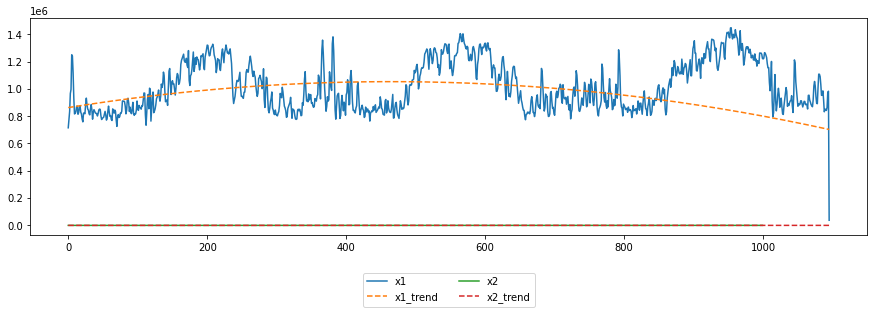

In [403]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

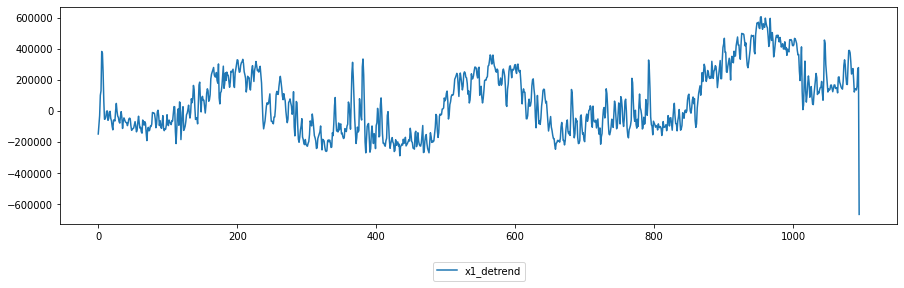

In [404]:
x1_detrend = x1 - x1_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x1_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [405]:

x_lbl = np.column_stack([x1_detrend,  x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1096, 3)
[[-1.48114559e+05  0.00000000e+00  1.00000000e+00]
 [-8.89753720e+04  1.00000000e+00  1.00000000e+00]
 [-3.04193101e+04  2.00000000e+00  1.00000000e+00]
 ...
 [ 2.67929070e+05  1.09300000e+03  0.00000000e+00]
 [ 2.79091088e+05  1.09400000e+03  0.00000000e+00]
 [-6.65258374e+05  1.09500000e+03  0.00000000e+00]]


In [406]:
x_train_max = x_lbl[x_lbl[:, 2]==1, :1].max(axis=0)
x_train_max.tolist()+[1]*2

[382867.0084904275, 1, 1]

In [407]:
x_train_max = x_lbl[x_lbl[:, 2]==1, :1].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[382867.0084904275, 1, 1]


In [408]:

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[-3.86856416e-01  0.00000000e+00  1.00000000e+00]
 [-2.32392371e-01  1.00000000e+00  1.00000000e+00]
 [-7.94513746e-02  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.99796703e-01  1.09300000e+03  0.00000000e+00]
 [ 7.28950476e-01  1.09400000e+03  0.00000000e+00]
 [-1.73757038e+00  1.09500000e+03  0.00000000e+00]]


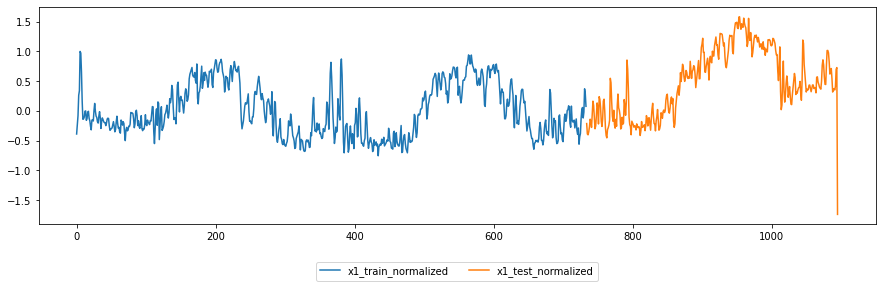

In [409]:

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [410]:

def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=2, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(2), target_cols=range(2), 
                            label_col=2, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(877, 200, 2) (877, 20, 2) (877,)


In [411]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(534, 200, 2) (534, 20, 2)
(343, 200, 2) (343, 20, 2)


In [412]:

n_hidden = 100

In [413]:
X_input_train.shape[2]

2

In [414]:

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name='input_33'), name='input_33', description="created by layer 'input_33'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_34'), name='input_34', description="created by layer 'input_34'")


In [415]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_29/strided_slice_3:0', description="created by layer 'lstm_29'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_29/while:4', description="created by layer 'lstm_29'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_29/while:5', description="created by layer 'lstm_29'")


In [416]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [417]:
input_train

<KerasTensor: shape=(None, 200, 1) dtype=float32 (created by layer 'input_33')>

In [418]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_30/transpose_1:0', description="created by layer 'lstm_30'")


In [419]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='time_distributed_13/Reshape_1:0', description="created by layer 'time_distributed_13'")


In [420]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm_29 (LSTM)                 [(None, 100),        40800       ['input_33[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_32 (BatchN  (None, 100)         400         ['lstm_29[0][0]']                
 ormalization)                                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


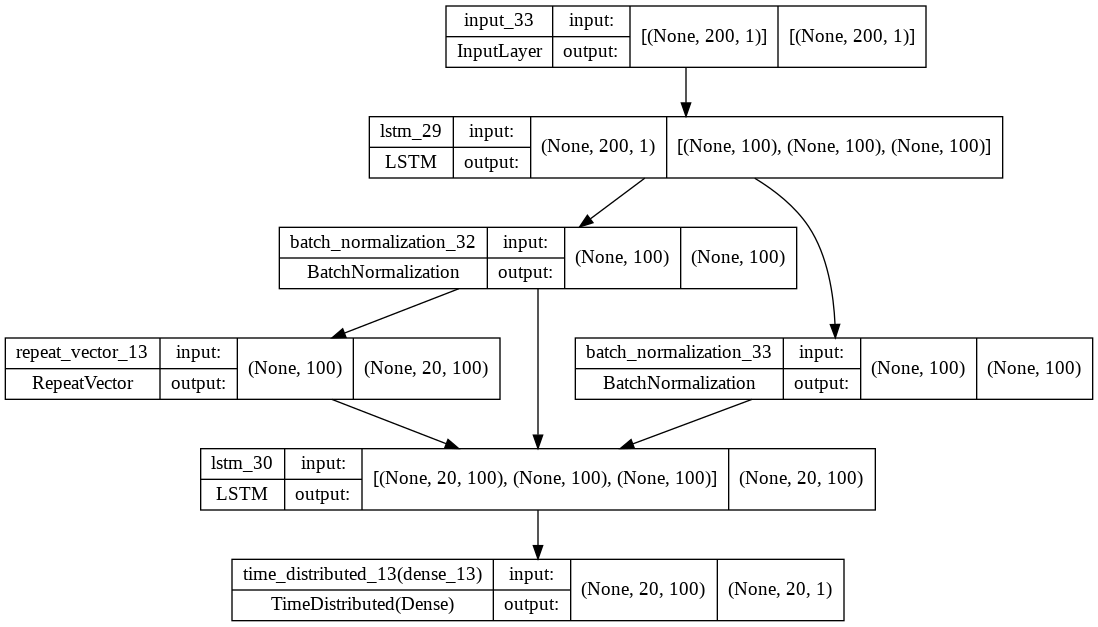

In [421]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [422]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 10s 733ms/step - loss: 86.3383 - mae: 3.6672 - val_loss: 0.1130 - val_mae: 0.2823
Epoch 2/100
5/5 [==============================] - 3s 578ms/step - loss: 0.3002 - mae: 0.4185 - val_loss: 0.0807 - val_mae: 0.2297
Epoch 3/100
5/5 [==============================] - 3s 576ms/step - loss: 0.1124 - mae: 0.2677 - val_loss: 0.1120 - val_mae: 0.2766
Epoch 4/100
5/5 [==============================] - 3s 556ms/step - loss: 0.1072 - mae: 0.2700 - val_loss: 0.0911 - val_mae: 0.2409
Epoch 5/100
5/5 [==============================] - 3s 575ms/step - loss: 0.1003 - mae: 0.2511 - val_loss: 0.0910 - val_mae: 0.2420
Epoch 6/100
5/5 [==============================] - 3s 569ms/step - loss: 0.1026 - mae: 0.2637 - val_loss: 0.0895 - val_mae: 0.2352
Epoch 7/100
5/5 [==============================] - 3s 578ms/step - loss: 0.0973 - mae: 0.2429 - val_loss: 0.0880 - val_mae: 0.2353
Epoch 8/100
5/5 [==============================] - 3s 573ms/step - loss: 0.1069 -

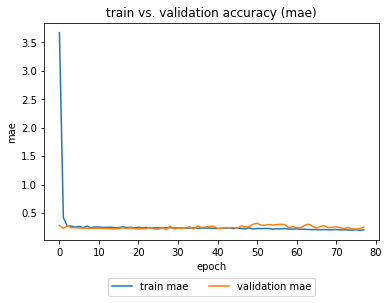

In [423]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [424]:
train_pred_detrend = model.predict(X_input_train[:, :, :1])*x_train_max[:1]
test_pred_detrend = model.predict(X_input_test[:, :, :1])*x_train_max[:1]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :1]*x_train_max[:1]
test_true_detrend = X_output_test[:, :, :1]*x_train_max[:1]
print(train_true_detrend.shape, test_true_detrend.shape)

(534, 20, 1) (343, 20, 1)
(534, 20, 1) (343, 20, 1)


array([[[ 72936.46981877,    734.        ],
        [ 60712.24524522,    735.        ],
        [ 55794.75986162,    736.        ],
        ...,
        [  5793.63582469,    751.        ],
        [  7364.7535663 ,    752.        ],
        [  9117.91735438,    753.        ]],

       [[ 42753.42757896,    735.        ],
        [ 52631.78325827,    736.        ],
        [ 58836.99239503,    737.        ],
        ...,
        [  7570.49600733,    752.        ],
        [  7131.26549127,    753.        ],
        [  6997.27545913,    754.        ]],

       [[-10354.22903108,    736.        ],
        [ 21853.82088275,    737.        ],
        [ 38929.0571331 ,    738.        ],
        ...,
        [-57705.8867768 ,    753.        ],
        [-62978.29035122,    754.        ],
        [-67794.09831967,    755.        ]],

       ...,

       [[194941.97411008,   1074.        ],
        [195523.21611747,   1075.        ],
        [197836.79664166,   1076.        ],
        ...,
     

In [425]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(534, 20, 2) (343, 20, 2)
(534, 20, 2) (343, 20, 2)


In [438]:
train_pred_detrend

array([[[ 2.27874183e+05,  2.00000000e+02],
        [ 2.07440298e+05,  2.01000000e+02],
        [ 1.98354164e+05,  2.02000000e+02],
        ...,
        [ 1.53676279e+05,  2.17000000e+02],
        [ 1.53541489e+05,  2.18000000e+02],
        [ 1.53434061e+05,  2.19000000e+02]],

       [[ 2.53290319e+05,  2.01000000e+02],
        [ 2.26826852e+05,  2.02000000e+02],
        [ 2.12737747e+05,  2.03000000e+02],
        ...,
        [ 1.49287217e+05,  2.18000000e+02],
        [ 1.49046950e+05,  2.19000000e+02],
        [ 1.48855382e+05,  2.20000000e+02]],

       [[ 2.66073262e+05,  2.02000000e+02],
        [ 2.34807211e+05,  2.03000000e+02],
        [ 2.17585766e+05,  2.04000000e+02],
        ...,
        [ 1.46702128e+05,  2.19000000e+02],
        [ 1.46421548e+05,  2.20000000e+02],
        [ 1.46197050e+05,  2.21000000e+02]],

       ...,

       [[ 1.76920100e+04,  7.31000000e+02],
        [ 3.62670509e+04,  7.32000000e+02],
        [ 4.58093981e+04,  7.33000000e+02],
        ...,
     

In [426]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 1]**2)*x1_trend_param[0] + dt[:, :, 1]*x1_trend_param[1] + x1_trend_param[2]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (534, 20, 1)
train_true: (534, 20, 1)
test_pred: (343, 20, 1)
test_true: (343, 20, 1)


In [446]:
data_final['train_true'].shape

(534, 20, 1)

In [444]:
data_final['train_pred'].reshape(534,20)

array([[1219319.49268804, 1199350.54640492, 1190727.5900817 , ...,
        1152785.9492928 , 1153086.14738598, 1153411.94561011],
       [1245200.56816303, 1219200.27865037, 1205572.58895017, ...,
        1148831.87579189, 1149024.83500051, 1149264.73164972],
       [1258446.68832845, 1227642.05358435, 1210880.26217531, ...,
        1146680.01300368, 1146830.89769962, 1147036.10231709],
       ...,
       [1008104.1122495 , 1026208.56034773, 1035278.55298577, ...,
         974611.66007217,  974355.39555618,  974518.16349111],
       [1048229.15170299, 1039242.51450755, 1034290.71513848, ...,
         959749.57635761,  960030.18443451,  960632.32800539],
       [1067066.60591434, 1044996.8500343 , 1033284.44497403, ...,
         958414.3225257 ,  959229.12747405,  960227.17333873]])

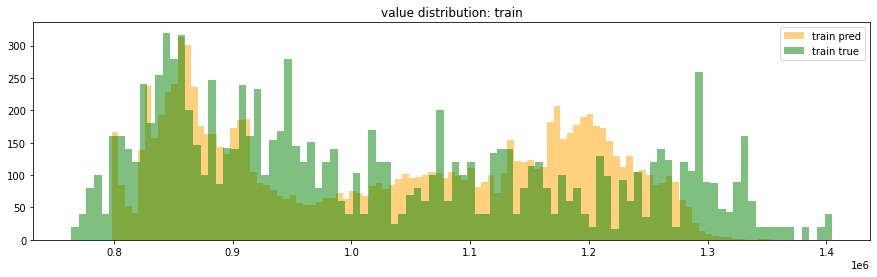

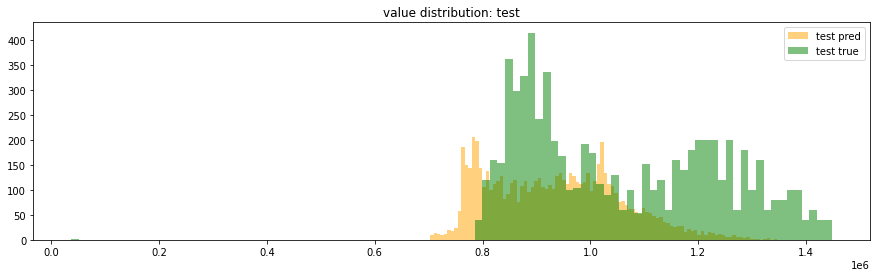

In [291]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

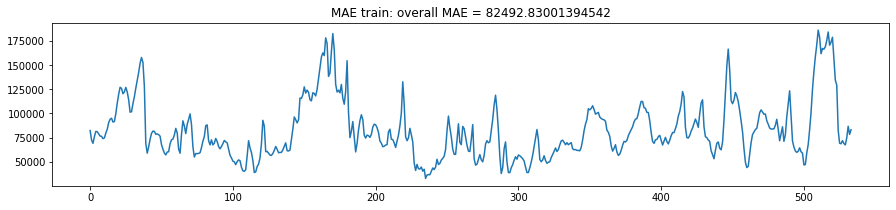

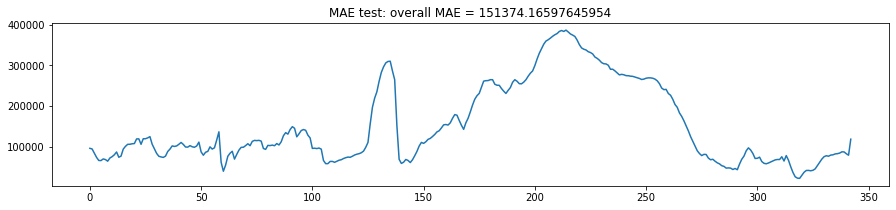

In [432]:

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

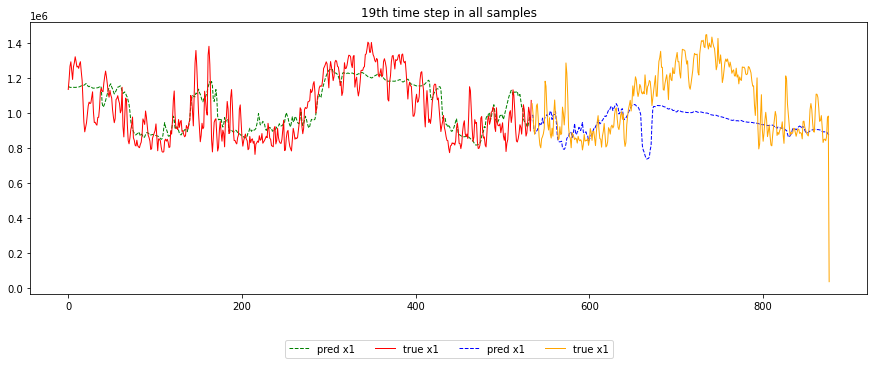

In [435]:
ith_timestep = max(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0], ['x1']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

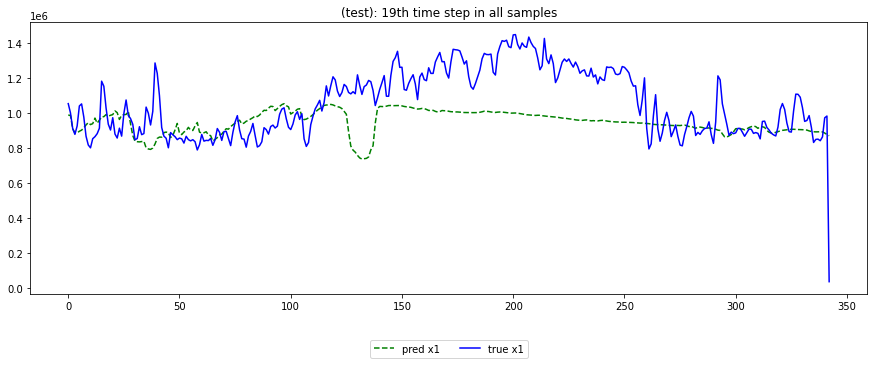

In [436]:

lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0], ['x1'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color='green', label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color='blue', label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [317]:

n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

In [318]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='lstm_23/transpose_1:0', description="created by layer 'lstm_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_23/while:4', description="created by layer 'lstm_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_23/while:5', description="created by layer 'lstm_23'")


In [319]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [320]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector_10/Tile:0', description="created by layer 'repeat_vector_10'")


In [321]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_24/transpose_1:0', description="created by layer 'lstm_24'")


In [322]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation_3/Softmax:0', description="created by layer 'activation_3'")


In [323]:
encoder_stack_h

<KerasTensor: shape=(None, 200, 100) dtype=float32 (created by layer 'lstm_23')>

In [324]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_27/batchnorm/add_1:0', description="created by layer 'batch_normalization_27'")


In [325]:

decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")


In [326]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='time_distributed_10/Reshape_1:0', description="created by layer 'time_distributed_10'")


In [327]:

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm_23 (LSTM)                 [(None, 200, 100),   40800       ['input_27[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_25 (BatchN  (None, 100)         400         ['lstm_23[0][1]']                
 ormalization)                                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


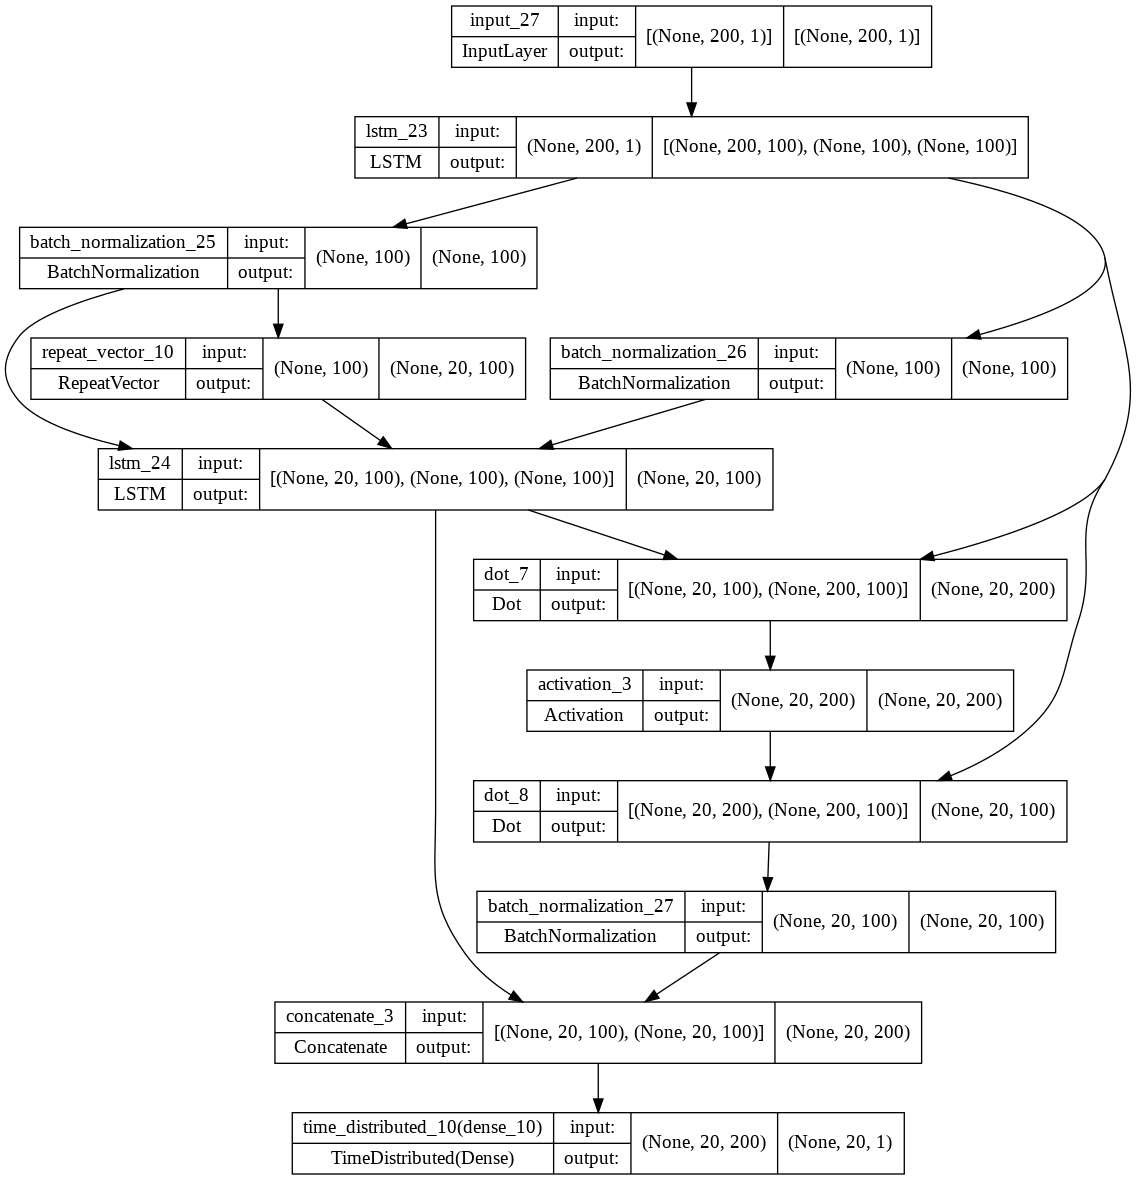

In [328]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [329]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 11s 766ms/step - loss: 33.3321 - mae: 3.0766 - val_loss: nan - val_mae: nan
Epoch 2/100
5/5 [==============================] - 3s 631ms/step - loss: 2.3900 - mae: 0.8048 - val_loss: 3.2720 - val_mae: 0.6770
Epoch 3/100
5/5 [==============================] - 3s 629ms/step - loss: 0.9671 - mae: 0.6370 - val_loss: 8794025532325888.0000 - val_mae: 29311370.0000
Epoch 4/100
5/5 [==============================] - 3s 640ms/step - loss: 0.7686 - mae: 0.5749 - val_loss: 73.4686 - val_mae: 1.0024
Epoch 5/100
5/5 [==============================] - 3s 640ms/step - loss: 0.6248 - mae: 0.5513 - val_loss: 0.1084 - val_mae: 0.2836
Epoch 6/100
5/5 [==============================] - 3s 635ms/step - loss: 0.4603 - mae: 0.5044 - val_loss: 0.0925 - val_mae: 0.2608
Epoch 7/100
5/5 [==============================] - 3s 638ms/step - loss: 0.4209 - mae: 0.4855 - val_loss: 0.0770 - val_mae: 0.2343
Epoch 8/100
5/5 [==============================] - 3s 641ms/step

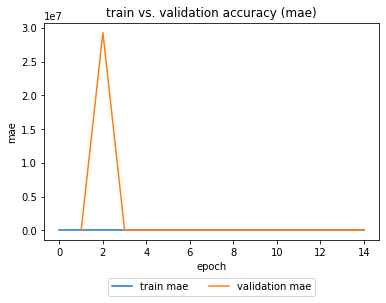

In [330]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [331]:
train_pred_detrend = model.predict(X_input_train[:, :, :1])*x_train_max[:1]
test_pred_detrend = model.predict(X_input_test[:, :, :1])*x_train_max[:1]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :1]*x_train_max[:1]
test_true_detrend = X_output_test[:, :, :1]*x_train_max[:1]
print(train_true_detrend.shape, test_true_detrend.shape)

(534, 20, 1) (343, 20, 1)
(534, 20, 1) (343, 20, 1)


In [332]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(534, 20, 2) (343, 20, 2)
(534, 20, 2) (343, 20, 2)


In [333]:
dtf_enc_dec = data_final.copy()
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 1]**2)*x1_trend_param[0] + dt[:, :, 1]*x1_trend_param[1] + x1_trend_param[2]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (534, 20, 1)
train_true: (534, 20, 1)
test_pred: (343, 20, 1)
test_true: (343, 20, 1)


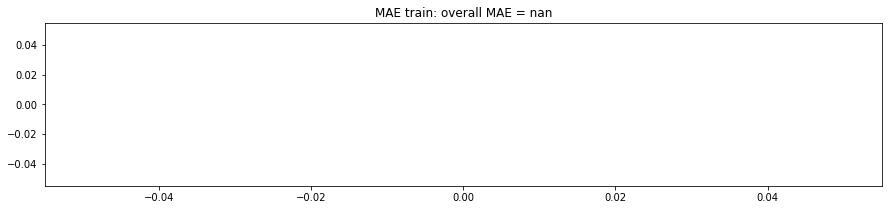

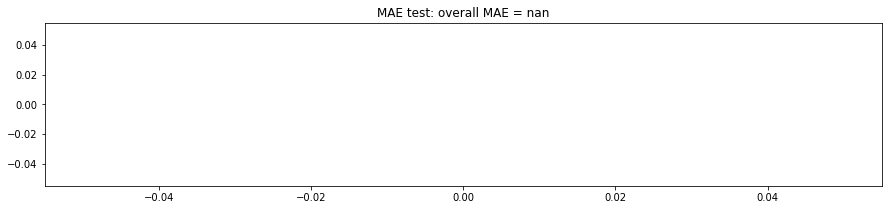

In [334]:

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

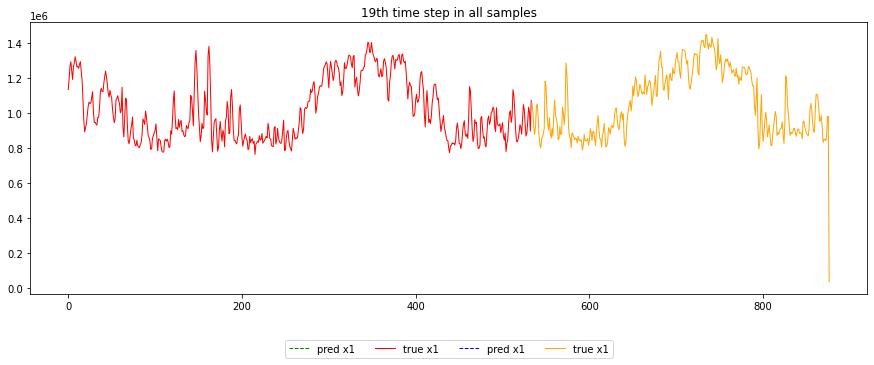

In [335]:
ith_timestep = max(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0], ['x1']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

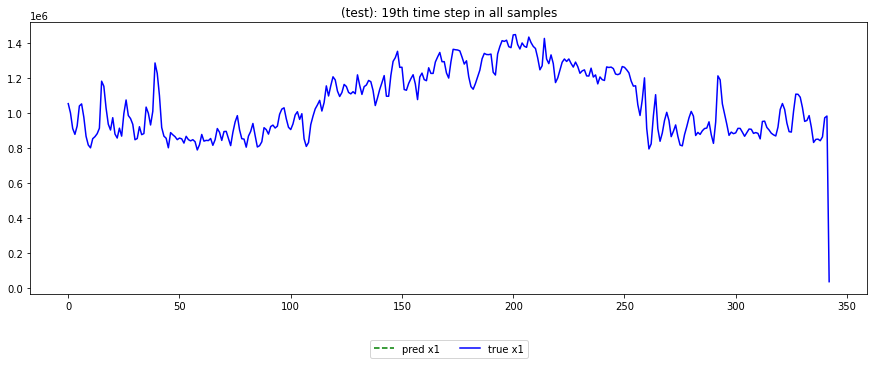

In [336]:

lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0], ['x1'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color='green', label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color='blue', label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()